### Comprehensive Survival notebook

####  A  detailed full blown and comprehensive notebook on survival models with different likelihoods using different approximation schemes: Laplace, SVGP, EP, EP(Parallel), EPDTC(Sparse EP), EP-Var(New sparse GP model) and possibly Power EP(in future) all done in GPy.

We use Log-Logistic and Weibull likelihoods on the Leukemia dataset also accounting for right-censoring. 
Credits to Alan Saul for sometips and some parts of code. A similar notebook also exists on a simulated survival dataset. Leukemia dataset has 1043 datapoints out of which about 300 are censored observations. Short summary: SVGP is very fast, faster than Laplace, EP is the slowest, parallel EPDTC(Sparse EP) part is the fastest among all EP versions and gives better results than SVGP and is almost as fast as Laplace !!. I use about 10% of the data as inducing points. We can also plot the positionof inducing points for each of the sparse methods and compare their placement. 
More analysis is to be done.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import matplotlib
import GPy

In [2]:
from GPy.plotting import Tango
from GPy.plotting.matplot_dep.util import fixed_inputs
from GPy.plotting.matplot_dep.base_plots import gpplot
import matplotlib.ticker as ticker
import pods
import pylab as pb

import pandas as pd
import numpy as np
from sklearn import cross_validation

 /u/26/dhakaa1/unix/anaconda2/envs/gpy27-devel/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.


In [3]:
import pods

In [4]:
matplotlib.use('pgf')
%matplotlib inline

 /u/26/dhakaa1/unix/anaconda2/envs/gpy27-devel/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning: This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.



In [5]:
def optimize_model(m):
    m.Z.fix()
    [m.optimize('scg', messages=1, max_iters=50) for i in range(3)]
    [m.optimize('lbfgs', messages=1, max_iters=30) for i in range(3)]
    m.Z.unconstrain()
    m.optimize('lbfgs', messages=1, max_iters=700)

In [6]:
seed=120
cens_perc= 10.0
D = 2
np.random.seed(seed)
shape1 = 2.0
shape2 = 0.96

####  Load and preprocess leukemia data

In [7]:
leukemia_data = pods.datasets.leukemia()
N = 2000
print leukemia_data.keys()
inds = np.random.permutation(range(leukemia_data['X'].shape[0]))[:N]

lc = 1 - leukemia_data['censoring'][inds, None]
Y_metadata = dict()
Y_metadata['censored'] = lc
Y = leukemia_data['Y'][inds, None]
Xcovs = leukemia_data['X'][inds, :]


Xcovs = Xcovs[:, 3:7]

WBC_orig = Xcovs[:,2].copy()
Xcovs[:,2] = np.log10(Xcovs[:,2] + 0.3)

X_original = Xcovs.copy()
Y_original = Y.copy()

cond_inds = np.array([0, 2, 3])
Xcovs_means = np.mean(Xcovs, axis=0)
Xcovs_std = np.std(Xcovs, axis=0)
Xcovs[:, cond_inds] = (Xcovs[:, cond_inds] - np.mean(Xcovs[:, cond_inds], axis=0))/np.std(Xcovs[:, cond_inds], axis=0)

Y_gmean = float(sp.stats.gmean(Y))
Y = Y/Y_gmean

print Y.mean()
print Y.var()


[u'files', u'license', u'citation', 'censoring', u'details', u'urls', 'Y', 'X', u'size']
3.94866009424
44.2116835319


In [8]:
Y_metadata = dict()
Y_metadata['censored'] = lc

#### Make a model with inference using SVGP with different observation models

In [9]:
def make_svgp_model(Xcovs, Y, lik_cat='loglog', Y_metadata=None, mean_function=None, name=None):
    #Z = X.copy()
    kern_f = GPy.kern.RBF(Xcovs.shape[1], variance=10.0, lengthscale=(Xcovs.max(axis=0) - Xcovs.min(axis=0))/6.0, ARD=True, name='f_rbf') 
    kern_f += GPy.kern.Bias(Xcovs.shape[1], variance=0.1, name='f_bias')
    kern_f += GPy.kern.White(Xcovs.shape[1], variance=1e-5, name='f_white')

    kern_f.name = 'f_kern'
#     het_ll = HetLogLogistic()

    if lik_cat == 'loglog':
        lik = GPy.likelihoods.LogLogistic()
    elif lik_cat == 'weibull':
        lik = GPy.likelihoods.Weibull()
    elif lik_cat == 'loggauss':
        lik = GPy.likelihoods.LogGaussian()
    else:
        raise Exception('No valid likelihood defined !!')

    num_inducing = int(Xcovs.shape[0]*0.1)
    Z = np.random.permutation(Xcovs.copy())[:num_inducing, :]
    
    lm = GPy.core.SVGP(X=Xcovs.copy(), Y=Y.copy(), Z=Z.copy(), kernel=kern_f.copy(), likelihood=lik.copy(), mean_function=mean_function, Y_metadata=Y_metadata, name=name)
    return lm

####  Sparse EP (EPDTC), GPy doesnt have EP_FITC unfortunately, another sparse EP family is the power EP which can also be tried here ...
Make a model with inference using EP-DTC Approximation with different observation models


In [10]:
def make_epdtc_model(Xcovs, Y, lik_cat='loglog', Y_metadata=None, mean_function=None, name=None, parallel_updates=False):
    kern_f = GPy.kern.RBF(Xcovs.shape[1], variance=10.0, lengthscale=(Xcovs.max(axis=0) - Xcovs.min(axis=0))/6.0, ARD=True, name='f_rbf') 
    kern_f += GPy.kern.Bias(Xcovs.shape[1], variance=0.1, name='f_bias')
    kern_f += GPy.kern.White(Xcovs.shape[1], variance=1e-5, name='f_white')

    kern_f.name = 'f_kern'
#     het_ll = HetLogLogistic()
    epdtc = GPy.inference.latent_function_inference.EPDTC(ep_mode='alternated',  parallel_updates=parallel_updates)

    if lik_cat == 'loglog':
        lik = GPy.likelihoods.LogLogistic()
    elif lik_cat == 'weibull':
        lik = GPy.likelihoods.Weibull()
    elif lik_cat == 'loggauss':
        lik = GPy.likelihoods.LogGaussian()
    else:
        raise Exception('No valid likelihood defined !!')

    num_inducing = int(Xcovs.shape[0]*0.1)
    Z = np.random.permutation(Xcovs.copy())[:num_inducing, :]
        
    lm = GPy.core.SparseGP(X=Xcovs.copy(), Y=Y.copy(), Z=Z.copy(), kernel=kern_f.copy(), inference_method=epdtc, likelihood=lik.copy(), mean_function=mean_function, Y_metadata=Y_metadata, name=name)
    return lm


#### Make a model with inference using EP-Var Approximation with different observation models

In [11]:

def make_epvar_model(Xcovs, Y, lik_cat='loglog', Y_metadata=None, mean_function=None, name=None, parallel_updates=False):
    kern_f = GPy.kern.RBF(Xcovs.shape[1], variance=10.0, lengthscale=(Xcovs.max(axis=0) - Xcovs.min(axis=0))/6.0, ARD=True, name='f_rbf') 
    kern_f += GPy.kern.Bias(Xcovs.shape[1], variance=0.1, name='f_bias')
    kern_f += GPy.kern.White(Xcovs.shape[1], variance=1e-5, name='f_white')

    kern_f.name = 'f_kern'
#     het_ll = HetLogLogistic()
    epvar = GPy.inference.latent_function_inference.EP_Var(ep_mode='alternated',  parallel_updates=parallel_updates)

    if lik_cat == 'loglog':
        lik = GPy.likelihoods.LogLogistic()
    elif lik_cat == 'weibull':
        lik = GPy.likelihoods.Weibull()
    elif lik_cat == 'loggauss':
        lik = GPy.likelihoods.LogGaussian()
    else:
        raise Exception('No valid likelihood defined !!')

    num_inducing = int(Xcovs.shape[0]*0.1)
    Z = np.random.permutation(Xcovs.copy())[:num_inducing, :]
        
    lm = GPy.core.SparseGP(X=Xcovs.copy(), Y=Y.copy(), Z=Z.copy(), kernel=kern_f.copy(), inference_method=epvar, likelihood=lik.copy(), mean_function=mean_function, Y_metadata=Y_metadata, name=name)
    return lm


#### Make a model with inference using Laplace Approximation with different observation models

In [12]:
def make_laplace_model(Xcovs, Y, lik_cat='loglog', Y_metadata=None, mean_function=None, name=None):
    kern_se = GPy.kern.RBF(Xcovs.shape[1], variance=10.0, lengthscale=(Xcovs.max(axis=0) - Xcovs.min(axis=0))/6.0, ARD=True, name='f_rbf') 
    kern_bias = GPy.kern.Bias(Xcovs.shape[1], variance=0.1, name='f_bias')
    kern_white = GPy.kern.White(Xcovs.shape[1], variance=1e-5, name='f_white')
    kern_Linear = GPy.kern.Linear(input_dim=Xcovs.shape[1], ARD=1)
    kernelleu = kern_se + kern_bias + kern_white
    kernelleu.name = 'f_kern'
    laplacian_inf = GPy.inference.latent_function_inference.Laplace()
    
    if lik_cat == 'loglog':
        lik = GPy.likelihoods.LogLogistic()
    elif lik_cat == 'weibull':
        lik = GPy.likelihoods.Weibull()
    elif lik_cat == 'loggauss':
        lik = GPy.likelihoods.Loggaussian()
    m_lap = GPy.core.GP(X=Xcovs, Y=Y.copy(), kernel=kernelleu.copy(), likelihood=lik.copy(), inference_method=laplacian_inf, name=name, Y_metadata=Y_metadata)
    return m_lap

####  EP-Alternate means that the site parameters are optimised just once in the beginning.

In [13]:
def make_ep_alt_model(Xcovs, Y, lik_cat='loglog', Y_metadata=None, mode='alternated', name=None, parallel_updates=True):
    kern_se = GPy.kern.RBF(Xcovs.shape[1], variance=10.0, lengthscale=(Xcovs.max(axis=0) - Xcovs.min(axis=0))/6.0, ARD=True, name='f_rbf') 
    kern_bias = GPy.kern.Bias(Xcovs.shape[1], variance=0.1, name='f_bias')
    kern_white = GPy.kern.White(Xcovs.shape[1], variance=1e-5, name='f_white')
    kern_Linear = GPy.kern.Linear(input_dim=Xcovs.shape[1], ARD=1)
    kernelleu = kern_se + kern_bias + kern_white
    kernelleu.name = 'f_kern'
#     laplacian_inf = GPy.inference.latent_function_inference.expectation_propagation()
    ep_alt = GPy.inference.latent_function_inference.EP(ep_mode=mode, parallel_updates=parallel_updates)
    
    if lik_cat == 'loglog':
        lik = GPy.likelihoods.LogLogistic()
    elif lik_cat == 'weibull':
        lik = GPy.likelihoods.Weibull()
    elif lik_cat == 'loggauss':
        lik = GPy.likelihoods.Loggaussian()
    m_ep_alt = GPy.core.GP(X=Xcovs, Y=Y.copy(), kernel=kernelleu.copy(), likelihood=lik.copy(), inference_method=ep_alt, Y_metadata=Y_metadata, name='survival_ep_alt')
    return m_ep_alt
    

###  Make SVGP models for different observation models (with varying number of inducing points)

In [18]:
# %timeit
m_lg_svgp = make_svgp_model(Xcovs, Y, lik_cat='loglog', Y_metadata=Y_metadata, name='survival_leu_svgp_loglog')

In [19]:
# %timeit
m_w_svgp = make_svgp_model(Xcovs,Y, lik_cat='weibull', Y_metadata=Y_metadata, name='survival_leu_svgp_weibull')

In [20]:
print(m_lg_svgp)


Name : survival_leu_svgp_loglog
Objective : 2450.95588526
Number of Parameters : 5988
Number of Optimization Parameters : 5988
Updates : True
Parameters:
  survival_leu_svgp_loglog.  |      value  |  constraints  |  priors
  inducing_inputs            |   (104, 4)  |               |        
  f_kern.f_rbf.variance      |       10.0  |      +ve      |        
  f_kern.f_rbf.lengthscale   |       (4,)  |      +ve      |        
  f_kern.f_bias.variance     |        0.1  |      +ve      |        
  f_kern.f_white.variance    |      1e-05  |      +ve      |        
  LogLogistic.r_log_shape    |        1.0  |      +ve      |        
  q_u_chol                   |  (5460, 1)  |               |        
  q_u_mean                   |   (104, 1)  |               |        


In [21]:
%timeit m_lg_svgp.optimize('lbfgs', max_iters=900)

1 loop, best of 3: 51.6 s per loop


In [28]:
print(m_lg_svgp)


Name : survival_leu_svgp_loglog
Objective : 1640.84622982
Number of Parameters : 5988
Number of Optimization Parameters : 5988
Updates : True
Parameters:
  survival_leu_svgp_loglog.  |              value  |  constraints  |  priors
  inducing_inputs            |           (104, 4)  |               |        
  f_kern.f_rbf.variance      |      6.89675160553  |      +ve      |        
  f_kern.f_rbf.lengthscale   |               (4,)  |      +ve      |        
  f_kern.f_bias.variance     |    0.0275139087119  |      +ve      |        
  f_kern.f_white.variance    |  7.78354389204e-06  |      +ve      |        
  LogLogistic.r_log_shape    |     0.908691572939  |      +ve      |        
  q_u_chol                   |          (5460, 1)  |               |        
  q_u_mean                   |           (104, 1)  |               |        


In [29]:
print(m_lg_svgp['f_kern.f_rbf.lengthscale'])

  index  |  survival_leu_svgp_loglog.f_kern.f_rbf.lengthscale  |  constraints  |  priors
  [0]    |                                         3.03985210  |      +ve      |        
  [1]    |                                        14.53128799  |      +ve      |        
  [2]    |                                         2.61195363  |      +ve      |        
  [3]    |                                         4.62449979  |      +ve      |        


In [30]:
m_w_svgp.optimize('lbfgs', max_iters=1500)

In [31]:
print(m_w_svgp)
print(m_w_svgp['f_kern.f_rbf.lengthscale'])


Name : survival_leu_svgp_weibull
Objective : 1708.06369349
Number of Parameters : 5988
Number of Optimization Parameters : 5988
Updates : True
Parameters:
  survival_leu_svgp_weibull.  |              value  |  constraints  |  priors
  inducing_inputs             |           (104, 4)  |               |        
  f_kern.f_rbf.variance       |      1.00850303682  |      +ve      |        
  f_kern.f_rbf.lengthscale    |               (4,)  |      +ve      |        
  f_kern.f_bias.variance      |     0.016614949035  |      +ve      |        
  f_kern.f_white.variance     |  5.82811020332e-06  |      +ve      |        
  Weibull.r_weibull_shape     |     0.576265171482  |      +ve      |        
  q_u_chol                    |          (5460, 1)  |               |        
  q_u_mean                    |           (104, 1)  |               |        
  index  |  survival_leu_svgp_weibull.f_kern.f_rbf.lengthscale  |  constraints  |  priors
  [0]    |                                          

###  Compare with laplace models

In [35]:
%timeit m_leu_ll_lap = make_laplace_model(Xcovs, Y, lik_cat='loglog', Y_metadata=Y_metadata, mean_function=None, name='survival_leu_lap_loglogistic')

In [36]:
m_leu_wei_lap = make_laplace_model(Xcovs, Y, lik_cat='weibull', Y_metadata=Y_metadata, mean_function=None, name='survival_leu_weibull_loglogistic')

In [37]:
# m_leu_lg_lap = make_laplace_model(Xcovs, Y, lik_cat='loggaussian', Y_metadata=Y_metadata, mean_function=None, name='survival_leu_weibull_loglogistic')

In [38]:
%timeit m_leu_ll_lap.optimize('bfgs', max_iters=900)

In [40]:
print(m_leu_ll_lap)
print(m_leu_ll_lap['f_kern.f_rbf.lengthscale'])


Name : survival_leu_lap_loglogistic
Objective : 1652.29854105
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  survival_leu_lap_loglogistic.  |              value  |  constraints  |  priors
  f_kern.f_rbf.variance          |      8.91102813966  |      +ve      |        
  f_kern.f_rbf.lengthscale       |               (4,)  |      +ve      |        
  f_kern.f_bias.variance         |      2.17181289126  |      +ve      |        
  f_kern.f_white.variance        |  9.99208749174e-06  |      +ve      |        
  LogLogistic.r_log_shape        |     0.902113462476  |      +ve      |        
  index  |  survival_leu_lap_loglogistic.f_kern.f_rbf.lengthscale  |  constraints  |  priors
  [0]    |                                             3.42444247  |      +ve      |        
  [1]    |                                             0.33362225  |      +ve      |        
  [2]    |                                             2.84634360  |      +ve     

In [41]:
%timeit m_leu_wei_lap.optimize('bfgs', max_iters=900)

In [42]:
print(m_leu_wei_lap)
print(m_leu_wei_lap['f_kern.f_rbf.lengthscale'])


Name : survival_leu_weibull_loglogistic
Objective : 1707.96388088
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  survival_leu_weibull_loglogistic.  |              value  |  constraints  |  priors
  f_kern.f_rbf.variance              |     0.966106970997  |      +ve      |        
  f_kern.f_rbf.lengthscale           |               (4,)  |      +ve      |        
  f_kern.f_bias.variance             |    0.0313425155321  |      +ve      |        
  f_kern.f_white.variance            |  1.09080472463e-05  |      +ve      |        
  Weibull.r_weibull_shape            |     0.576770118214  |      +ve      |        
  index  |  survival_leu_weibull_loglogistic.f_kern.f_rbf.lengthscale  |  constraints  |  priors
  [0]    |                                                 2.32518756  |      +ve      |        
  [1]    |                                                 0.33336872  |      +ve      |        
  [2]    |                                

#### Compare with standard EP models with fixed site params(alternated mode), and secondly after updating site params at every hyperparam update(nested mode).

In [48]:
 m_loglog_ep_alt = make_ep_alt_model(Xcovs.copy(), Y.copy(), lik_cat='loglog', Y_metadata=Y_metadata, name='survival_ep_loglogistic')

In [49]:
print(m_loglog_ep_alt)


Name : survival_ep_alt
Objective : 1745.18443165
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  survival_ep_alt.         |  value  |  constraints  |  priors
  sum.f_rbf.variance       |   10.0  |      +ve      |        
  sum.f_rbf.lengthscale    |   (4,)  |      +ve      |        
  sum.f_bias.variance      |    0.1  |      +ve      |        
  sum.f_white.variance     |  1e-05  |      +ve      |        
  LogLogistic.r_log_shape  |    1.0  |      +ve      |        


In [50]:
%timeit m_loglog_ep_alt.optimize('bfgs', max_iters=900)

1 loop, best of 3: 3min 27s per loop


In [34]:
# print(m_loglog_ep_alt)
# print(m_loglog_ep_alt['*rbf.lengthscale'])

In [55]:
%timeit m_weibull_ep_alt = make_ep_alt_model(Xcovs, Y, lik_cat='weibull', Y_metadata=Y_metadata, name='survival_ep_weibull')

 /u/26/dhakaa1/unix/anaconda2/envs/gpy27-devel/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning:Mean of empty slice


1 loop, best of 3: 37min 30s per loop


In [57]:
print(m_weibull_ep_alt)

NameError: name 'm_weibull_ep_alt' is not defined

In [ ]:
m_weibull_ep_alt.optimize('bfgs', max_iters=900)

In [ ]:
print(m_weibull_ep_alt)
print(m_weibull_ep_alt['f_kern.f_rbf.lengthscale'])

In [ ]:
# m_loglog_ep_nested = make_ep_alt_model(Xcovs, Y, lik_cat='loglog', Y_metadata=Y_metadata, name='survival_ep_loglogistic', mode='nested')

In [ ]:
# m_weibull_ep_nested = make_ep_alt_model(Xcovs, Y, lik_cat='weibull', Y_metadata=Y_metadata, name='survival_ep_loglogistic', mode='nested')

In [ ]:
# print(m_loglog_ep_nested)
# print(m_weibull_ep_nested))

In [ ]:
# m_loglog_ep_nested.optimize('bfgs', max_iters=900)

In [13]:
ep_var = GPy.inference.latent_function_inference.EP_Var(ep_mode='alternated', parallel_updates=True, delta=0.4, eta=0.7, epsilon=1e-2)
epdtc = GPy.inference.latent_function_inference.EPDTC(ep_mode ='alternated', parallel_updates=True)

In [19]:
likwei = GPy.likelihoods.Weibull()

In [20]:
liklog = GPy.likelihoods.LogLogistic()
kern_se = GPy.kern.RBF(Xcovs.shape[1], variance=10.0, lengthscale=(Xcovs.max(axis=0) - Xcovs.min(axis=0))/6.0, ARD=True, name='f_rbf') 
kern_bias = GPy.kern.Bias(Xcovs.shape[1], variance=0.1, name='f_bias')
kern_white = GPy.kern.White(Xcovs.shape[1], variance=1e-5, name='f_white')
kern_Linear = GPy.kern.Linear(input_dim=Xcovs.shape[1], ARD=1)
kernelleu = kern_se + kern_bias + kern_white

In [15]:
# print(Xcovs.shape)
# print(Y.shape)
num_inducing = int(Xcovs.shape[0]*0.1)
Z = np.random.permutation(Xcovs.copy())[:num_inducing, :]

In [21]:
# m_ep_var = GPy.core.SparseGP(X=Xcovs, Y=Y.copy(), Z=Z.copy(), kernel=kernelleu.copy(), likelihood=liklog.copy(), inference_method=ep_var, Y_metadata=Y_metadata, name='survival_ep_alt')

In [24]:
m_ep_dtc = GPy.core.SparseGP(X=Xcovs, Y=Y.copy(), Z=Z.copy(), kernel=kernelleu.copy(), likelihood=liklog.copy(), inference_method=epdtc, Y_metadata=Y_metadata, name='survival_ep_alt')

In [25]:
m_ep_dtc_wei = GPy.core.SparseGP(X=Xcovs, Y=Y.copy(), Z=Z.copy(), kernel=kernelleu.copy(), likelihood=likwei.copy(), inference_method=epdtc, Y_metadata=Y_metadata, name='survival_ep_alt_w')

In [27]:
# m_ep_var_wei = GPy.core.SparseGP(X=Xcovs, Y=Y.copy(), Z=Z.copy(), kernel=kernelleu.copy(), likelihood=likwei.copy(), inference_method=ep_var, Y_metadata=Y_metadata, name='survival_ep_alt_w')

####  Make a sparse EP(EPDTC) model with different observation models 

In [33]:
m_lg_epdtc = make_epdtc_model(Xcovs, Y, lik_cat='loglog', Y_metadata=Y_metadata, name='survival_leu_epdtc_loglog',parallel_updates=True)

In [37]:
print(m_lg_epdtc)


Name : survival_leu_epdtc_loglog
Objective : 2105.86771081
Number of Parameters : 424
Number of Optimization Parameters : 424
Updates : True
Parameters:
  survival_leu_epdtc_loglog.  |     value  |  constraints  |  priors
  inducing_inputs             |  (104, 4)  |               |        
  f_kern.f_rbf.variance       |      10.0  |      +ve      |        
  f_kern.f_rbf.lengthscale    |      (4,)  |      +ve      |        
  f_kern.f_bias.variance      |       0.1  |      +ve      |        
  f_kern.f_white.variance     |     1e-05  |      +ve      |        
  LogLogistic.r_log_shape     |       1.0  |      +ve      |        


In [38]:
%timeit m_lg_epdtc.optimize('lbfgs', max_iters=900)

1 loop, best of 3: 3min 12s per loop


In [39]:
print(m_lg_epdtc)
print(m_lg_epdtc['f_kern.f_rbf.lengthscale'])


Name : survival_leu_epdtc_loglog
Objective : 1645.52533042
Number of Parameters : 424
Number of Optimization Parameters : 424
Updates : True
Parameters:
  survival_leu_epdtc_loglog.  |              value  |  constraints  |  priors
  inducing_inputs             |           (104, 4)  |               |        
  f_kern.f_rbf.variance       |      9.47541118957  |      +ve      |        
  f_kern.f_rbf.lengthscale    |               (4,)  |      +ve      |        
  f_kern.f_bias.variance      |    0.0019833997702  |      +ve      |        
  f_kern.f_white.variance     |  6.37044649726e-08  |      +ve      |        
  LogLogistic.r_log_shape     |                1.0  |      +ve      |        
  index  |  survival_leu_epdtc_loglog.f_kern.f_rbf.lengthscale  |  constraints  |  priors
  [0]    |                                          3.08656229  |      +ve      |        
  [1]    |                                        128.27980918  |      +ve      |        
  [2]    |                    

In [ ]:
m_w_epdtc = make_epdtc_model(Xcovs, Y, lik_cat='weibull', Y_metadata=Y_metadata, name='survival_leu_epdtc_weibull',parallel_updates=True)

In [ ]:
print(m_w_epdtc)

In [ ]:
m_weibull_epdtc.optimize('lbfgs', max_iters=900)

In [ ]:
print(m_weibull_epdtc)
print(m_weibull_epdtc['f_kern.f_rbf.lengthscale'])

#### Make EPDTC model without parallel updates(just for comparison)

In [ ]:
# m_loglog_epdtc = make_epdtc_model(Xcovs, Y, lik_cat='loglog', Y_metadata=Y_metadata, name='survival_leu_epdtc_loglog', parallel_updates=False)

In [ ]:
print(m_loglog_epdtc_unparallel)

In [ ]:
m_loglog_epdtc_unparallel.optimize('lbfgs', max_iters=00)

In [ ]:
print(m_loglog_epdtc_unparallel)
print(m_loglog_epdtc_unparallel['f_kern.f_rbf.lengthscale'])

####  Code for plotting latent_function, we need to exponentiate the latent function, as this is a log-GP model. 

This will plot how the latent function changes in response to just one covariate keeping all other covariates fixed at their median values. 

In [23]:
def plot_f(m, dim, male=True, ax=None, save=False, rescale=True,
          fc=None, ec=None, formatting='pdf'):

    non_fixed_inputs = [dim]
    #inputs = fixed_inputs(m, non_fixed_inputs, 'median')
    inputs_mat = fixed_inputs(m, non_fixed_inputs, 'median', as_list=False)

    if male is not None:
        if male:
            inputs_mat[:,1] = -1.0
        else:
            inputs_mat[:,1] = 1.0

    mu, var = m._raw_predict(inputs_mat)

    two_std = 2*np.sqrt(var)
    #Scale back into 'days' scale
    mean = np.exp(mu)
    five = np.exp(mu - two_std)
    nf = np.exp(mu + two_std)
    x = inputs_mat[:, non_fixed_inputs]
    if rescale:
        #Rescale x back to standard range
        mean = mean*Y_gmean
        five = five*Y_gmean
        nf = nf*Y_gmean
        x = x*Xcovs_std[non_fixed_inputs] + Xcovs_means[non_fixed_inputs]

    #Sort for plotting
    s = np.argsort(x, axis=0)
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    if fc and ec:
        fc = fc
        ec = ec
    else:
        if male:
            fc = Tango.colorsHex['lightGreen']
            ec = Tango.colorsHex['darkGreen']
        else:
            fc = Tango.colorsHex['lightBlue']
            ec = Tango.colorsHex['darkBlue']
    gpplot(x[s], mean[s], five[s], nf[s], ax=ax, edgecol=ec, fillcol=fc)
    m.plot_data(visible_dims=[dim], ax=ax)
    m.plot_inducing(visible_dims=[dim], projection='2d')
    m.plot_inducing(visible_dims=[dim, 3], projection='3d')
    ax.semilogy()
    #ax.set_ylim(0, nf.max())
    ax.set_xlim(x.min(), x.max())

    if dim == 0:
        xlabel = 'Age'
    elif dim == 2:
        xlabel = 'log10(WBC + 0.3)'
    elif dim == 3:
        xlabel = 'Town deprevation index'
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Expected lifetime (days)')

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if save:
        if formatting == 'pdf':
            fig.savefig('Figures/non-linear-dose-response.pdf', transparent=True, bbox_inches='tight', format='pdf', dpi=1000)
        elif formatting == 'png':
            fig.savefig('Figures/non-linear-dose-response.png', transparent=True, bbox_inches='tight', format='png', dpi=1000)
        if formatting == 'eps':
            fig.savefig('Figures/non-linear-dose-response.eps', transparent=True, bbox_inches='tight', format='eps', dpi=1000)
    return ax

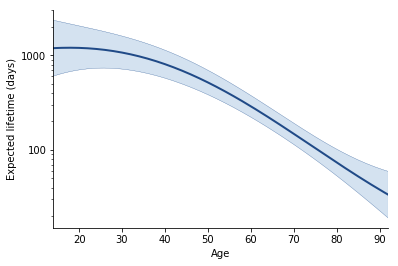

 /u/26/dhakaa1/unix/anaconda2/envs/gpy27-devel/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


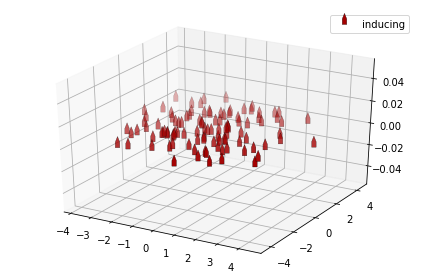

In [25]:
ax = plot_f(m_lg_svgp, 0, male=False, save=False, formatting='eps')

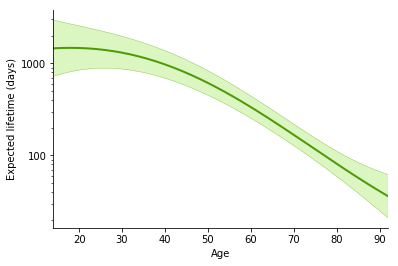

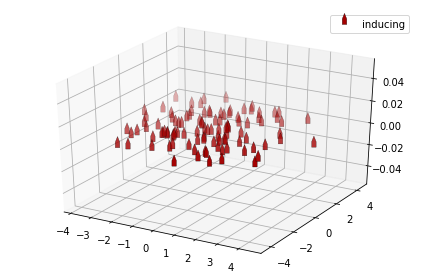

In [27]:
ax = plot_f(m_lg_svgp, 0, male=True, save=False)

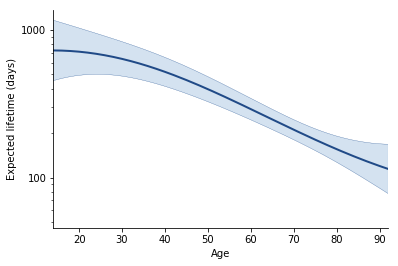

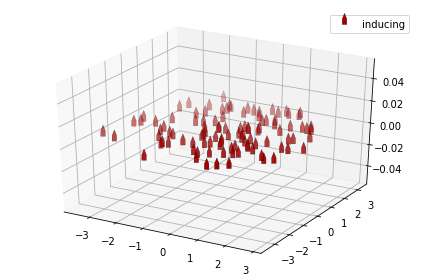

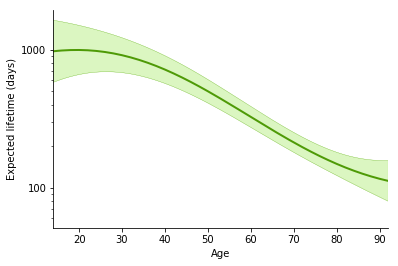

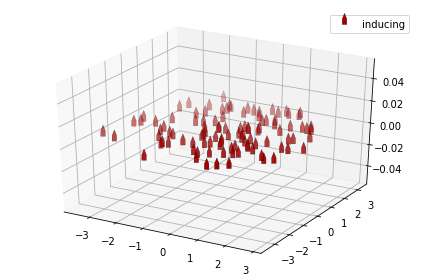

In [41]:
ax = plot_f(m_w_svgp, 0, male=False, save=False, formatting='eps')
ax = plot_f(m_w_svgp, 0, male=True, save=False, formatting='eps')

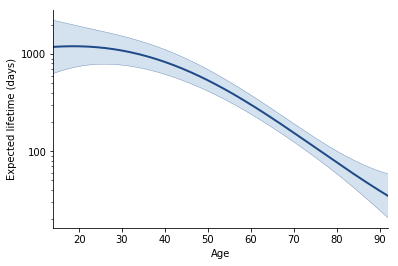

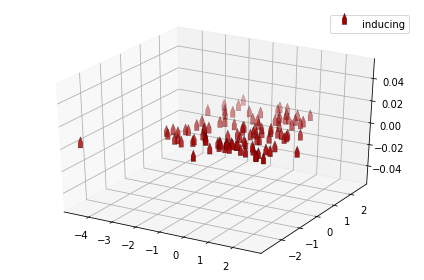

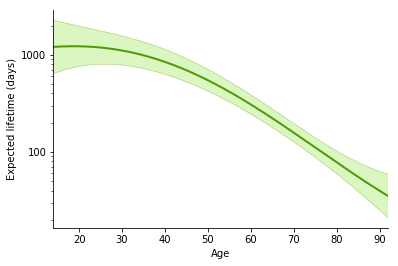

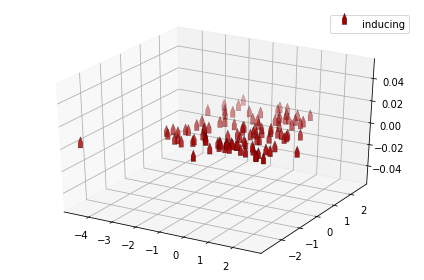

In [42]:
ax = plot_f(m_lg_epdtc, 0, male=False, save=False, formatting='eps')
ax = plot_f(m_lg_epdtc, 0, male=True, save=False, formatting='eps')

In [3]:
ax = plot_f(m_w_epdtc, 0, male=False, save=False, formatting='eps')
ax = plot_f(m_w_epdtc, 0, male=True, save=False, formatting='eps')


NameError: name 'plot_f' is not defined

This function will plot how the latent function changes in response to two covariates keeping all other covariates fixed at their median values. 

In [ ]:
def plot_f_2d(m, dim1, dim2, male=True, ax=None, save=False, rescale=True,
              fc=None, ec=None, cmap=None, formatting='pdf'):

    others = list(set(range(m.X.shape[1])) - set([dim1, dim2]))
    num_X = 40
    inputs_mat = np.zeros((num_X, m.X.shape[1]))
    inputs_mat[:,dim1] = np.linspace(m.X[:,dim1].min(), m.X[:,dim1].max(), num_X)
    inputs_mat[:,dim2] = np.linspace(m.X[:,dim2].min(), m.X[:,dim2].max(), num_X)

    XX, YY = np.meshgrid(inputs_mat[:,dim1], inputs_mat[:,dim2])
    
    final_inputs_mat = np.zeros((XX.flatten().shape[0], m.X.shape[1]))
    final_inputs_mat[:, dim1] = XX.flatten()
    final_inputs_mat[:, dim2] = YY.flatten()
    final_inputs_mat[:, others] = np.median(m.X.values, axis=0)[others]
    
    if male is not None:
        if male:
            final_inputs_mat[:,1] = -1.0
        else:
            final_inputs_mat[:,1] = 1.0
        
    mean_f_pred, var_f_pred = m._raw_predict(final_inputs_mat)  # mean_f_pred, var_f_pred
    
    mu = mean_f_pred
    var = var_f_pred
    
    two_std = 2*np.sqrt(var)
    #Scale back into 'days' scale
    mean = np.exp(mu)
    five = np.exp(mu - two_std)
    nf = np.exp(mu + two_std)
    if rescale:
        #Rescale x back to standard range
        mean = mean*Y_gmean
        five = five*Y_gmean
        nf = nf*Y_gmean
        if dim1 == 2:
            pass
            #XX = 10**XX - 0.3
        else:
            XX = XX*Xcovs_std[dim1] + Xcovs_means[dim1]

        if dim2 == 2:
            pass
            #YY = 10**YY - 0.3
        else:
            YY = YY*Xcovs_std[dim2] + Xcovs_means[dim2]
        
    #Sort for plotting
    if ax is None:
        #fig, ax = plt.subplots(1,1)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
    if fc and ec and cmap:
        fc = fc
        ec = ec
        cmap = cmap
    else:
        if male:
            fc = Tango.colorsHex['lightGreen']
            ec = Tango.colorsHex['darkGreen']
            cmap = matplotlib.cm.Greens_r
        else:
            fc = Tango.colorsHex['lightBlue']
            ec = Tango.colorsHex['darkBlue']
            cmap = matplotlib.cm.Blues_r

    Z_f = mean.reshape((num_X, num_X), order='C')
    ax.plot_surface(XX, YY, Z_f, rstride=1, cstride=1, cmap=cmap, lw=0.2, alpha=1.0)

    if dim1 == 0:
        xlabel = 'Age'
    elif dim1 == 2:
        xlabel = 'log10(WBC + 0.3)'
    elif dim1 == 3:
        xlabel = 'Town deprevation index'
    if dim2 == 0:
        ylabel = 'Age'
    elif dim2 == 2:
        ylabel = 'log10(WBC + 0.3)'
    elif dim2 == 3:
        ylabel = 'Town deprevation index'
        
    ax.set_xlabel("\n"+xlabel)
    ax.set_ylabel("\n"+ylabel)
    ax.set_zlabel("\n"+'Expected lifetime (days)')
    ax.view_init(elev=30., azim=34)
    ax.set_yticks(np.linspace(YY.min(), YY.max(), 6).round(1))
    ax.set_xticks(np.arange(0, 100, 10))
    
    #ax.set_yticklabels(np.linspace(YY.min(), YY.max(), 4))#,#rotation=-15,
                   #verticalalignment='baseline',
                   #horizontalalignment='left')
    #ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.yaxis.set_ticks_position('left')
    #ax.xaxis.set_ticks_position('bottom')

    ax.patch.set_facecolor('white')
    ax.w_xaxis.set_pane_color((0.8, 0.8, 0.8, 0.0))
    ax.w_yaxis.set_pane_color((0.8, 0.8, 0.8, 0.0))
    ax.w_zaxis.set_pane_color((0.8, 0.8, 0.8, 0.0))
    if save:
        if formatting == 'pdf':
            fig.savefig('Figures/2dnon-linear-dose-response.pdf', transparent=True, bbox_inches='tight', format='pdf', dpi=1000)
        elif formatting == 'png':
            fig.savefig('Figures/2dnon-linear-dose-response.png', transparent=True, bbox_inches='tight', format='png', dpi=1000)
        if formatting == 'eps':
            fig.savefig('Figures/2dnon-linear-dose-response.eps', transparent=True, bbox_inches='tight', format='eps', dpi=1000)
    return ax



In [ ]:
ax = plot_f_2d(m_lg_svgp, 0, 2, male=False, save=False)

#### Writing evaluation functions here .. 

In [ ]:
class SurvivalData:
    def __init__(self, Xtrain, Ytrain, Xtest=None, Ytest=None, Y_metadata_train=None, Y_metadata_test=None, K_fold=10):
        self.Xtrain = Xtrain
        self.Ytrain = Ytrain
        self.Xtest = Xtest
        self.Ytest = Ytest
        self.Y_metadata_train = Y_metadata_train
        self.Y_metadata_test = Y_metadata_test

class EvalModel:
    def __init__(self,m,SurvivalData):
        self.m = m
        self.sd = SurvivalData
    
    def get_log_likelihood(self, m=None):
        return self.m.log_likelihood
    
    def get_RMSE(self, m=None):
        '''Root mean squared Error.'''
        mu = self.m._raw_predict(self.sd.Xtest)
        predict_mean = self.m.likelihood.gp_link.transf(mu)
        target = self.Ytest
        rmse = np.mean((predict_mean - target)**2, axis=0)
        return rmse
    
    def get_MAE(self, m=None):
        '''Mean Absolute Error. '''
        mu = self.m._raw_predict(self.sd.Xtest)
        predict_mean = self.m.likelihood.gp_link.tranf(mu)
        target = self.Ytest
        diff = np.mean(np.abs((predict_mean - target)))
        return diff
        
    def get_NMSE(self, m=None):
        ''' '''
        predict_mean = self.m._raw_predict(self.sd.Xtest)
        predict_mean = self.m.likelihood.gp_link.transf(mu)
        nmse = np.mean((predict_mean - target)**2, axis=0) / np.sum((self.Ytest - np.mean(self.Ytrain))**2)
        return nmse
    
    def perform_eval(self, func, *args):
        self.func(*args)
    
    def get_log_predictive_likelihood(self, m=None, num_samples=1000):
        ''' log predictive likelihood '''
        return self.m.log_predictive_density_sampling(self.sd.Xtest, self.sd.Ytest, num_samples=num_samples, Y_metadata=self.Y_metadata_test)
    
#     def KFold_cross_validation(self, m, method, seed=42):
#         '''do cross fold validation using any one of the above evaluation measures.'''
#         np.random.seed(seed)
#         N = self.Xtrain.shape[0]
#         indices = np.range(N)
#         shuffle_inds = np.random.shuffle(indices)
#         quotient = N / self.KFold
#         train_inds, test_inds = shuffle_inds[:(self.KFold-1)*quotient], shuffle_inds[(self.KFold-1)*quotient:] 
#         train_X, test_X = self.Xtrain[train_inds], self.Xtrain[test_inds]
#         train_Y, test_Y = self.Ytrain[test_inds], self.Ytrain[test_inds]
#         err = []
#         for i in range(self.K_fold):
#             err[i] = self.perform_eval(method, m)
        
        